In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=32.0s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Null gene set

In [7]:
np.random.seed(0)
gs_size_list = [20, 100, 500]
n_rep=10
dic_nullset= {}

md.compute_stats(data_facs_ct)
df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.var['mean'].values
df_gene['std'] = np.sqrt(data_facs_ct.var['var'].values)
df_gene['cv'] = df_gene['std'].values/df_gene['mean'].values
df_gene['var'] = data_facs_ct.var['var'].values
df_gene['var_tech'] = data_facs_ct.var['var_tech'].values
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(data_facs_ct.shape[1])[:n_gene]
        gs_name = 'all_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(data_facs_ct.var_names[ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        # Select lowly- and highly- expressed random genes 
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'lowexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[:5000][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'highexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[-5000:][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# all_size20;rep0      n_gene=20  mean=8.21e-02 std=1.12e-01
# all_size20;rep1      n_gene=20  mean=1.18e-01 std=2.10e-01
# all_size20;rep2      n_gene=20  mean=1.07e-01 std=1.45e-01
# all_size20;rep3      n_gene=20  mean=1.16e-01 std=1.49e-01
# all_size20;rep4      n_gene=20  mean=5.27e-02 std=6.10e-02
# all_size20;rep5      n_gene=20  mean=9.67e-02 std=1.93e-01
# all_size20;rep6      n_gene=20  mean=1.51e-01 std=3.18e-01
# all_size20;rep7      n_gene=20  mean=7.55e-02 std=9.46e-02
# all_size20;rep8      n_gene=20  mean=5.16e-02 std=8.07e-02
# all_size20;rep9      n_gene=20  mean=5.88e-02 std=8.39e-02
# all_size100;rep0     n_gene=100 mean=9.58e-02 std=2.21e-01
# all_size100;rep1     n_gene=100 mean=9.76e-02 std=2.15e-01
# all_size100;rep2     n_gene=100 mean=1.09e-01 std=2.26e-01
# all_size100;rep3     n_gene=100 mean=8.32e-02 std=2.07e-01
# all_size100;rep4     n_gene=100 mean=1.15e-01 std=2.37e-01
# all_size100;rep5     n_gene=100 mean=1.34e-01 std=2.90e-01
# all_size100;rep6     n

### Test TRS

In [53]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [54]:
# Obtain TRS: This takes a lot of time.
from itertools import product
# null_trait_list = ['lowexp_size500;rep%d'%x for x in range(10)]
# null_trait_list = ['lowexp_size500;rep%d'%x for x in [1]]
null_trait_list = list(dic_nullset.keys())
start_time = time.time()
dic_trs={}

md_list = [['mean', 'mean_match', 1],
           ['mean', 'mean_match', 5],
           ['vst', 'mean_match', 1],
           ['vst', 'mean_match', 5],
           ['inv_std', 'mean_match', 1],
           ['inv_std', 'mean_match', 5]]

for trait in null_trait_list:
    for trs_opt,ctrl_opt,n_ctrl in md_list:
        term='%s;trs_opt=%s,ctrl_opt=%s,n_ctrl=%d'%(trait,trs_opt,ctrl_opt,n_ctrl)
        md.score_cell(data_facs_ct, dic_nullset[trait], suffix='',
                      trs_opt=trs_opt, ctrl_opt=ctrl_opt,
                      n_ctrl=n_ctrl, n_genebin=200, flag_correct_background=True,
                      return_list=['trs_tp','trs_ep', 'trs', 'trs_ctrl0'], verbose=False)
        dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
        dic_trs['%s;trs_opt=%s,tp'%(trait,trs_opt)] = data_facs_ct.obs['trs_tp'].values.copy()
        print('# %-50s time=%0.1fs'%(term,time.time()-start_time))

# all_size20;rep0;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=1.4s
# all_size20;rep0;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=5.7s
# all_size20;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=7.1s
# all_size20;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=11.4s
# all_size20;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=12.8s
# all_size20;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=17.1s
# all_size20;rep1;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=18.5s
# all_size20;rep1;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=22.8s
# all_size20;rep1;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=24.2s
# all_size20;rep1;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=28.6s
# all_size20;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=30.1s
# all_size20;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=34.4s
# all_size20;rep2;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=35.9s
# all_size20;rep2;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=40.3s
#

# all_size100;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=341.3s
# all_size100;rep9;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=342.8s
# all_size100;rep9;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=347.4s
# all_size100;rep9;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=349.0s
# all_size100;rep9;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=353.6s
# all_size100;rep9;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=355.1s
# all_size100;rep9;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=359.7s
# all_size500;rep0;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=361.6s
# all_size500;rep0;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=367.0s
# all_size500;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=368.8s
# all_size500;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=374.2s
# all_size500;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=376.0s
# all_size500;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=381.4s
# all_size500;rep1;trs_opt=mean,ctrl_opt

# lowexp_size20;rep7;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=702.9s
# lowexp_size20;rep7;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=707.1s
# lowexp_size20;rep7;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=708.5s
# lowexp_size20;rep7;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=712.6s
# lowexp_size20;rep8;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=714.1s
# lowexp_size20;rep8;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=718.3s
# lowexp_size20;rep8;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=719.7s
# lowexp_size20;rep8;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=723.9s
# lowexp_size20;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=725.2s
# lowexp_size20;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=729.4s
# lowexp_size20;rep9;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=730.8s
# lowexp_size20;rep9;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=735.0s
# lowexp_size20;rep9;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=736.4s
# lowexp_size20;re

# lowexp_size500;rep5;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=1006.7s
# lowexp_size500;rep5;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=1010.8s
# lowexp_size500;rep5;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=1012.2s
# lowexp_size500;rep5;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=1016.5s
# lowexp_size500;rep6;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=1017.9s
# lowexp_size500;rep6;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=1022.1s
# lowexp_size500;rep6;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=1023.5s
# lowexp_size500;rep6;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=1027.8s
# lowexp_size500;rep6;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=1029.2s
# lowexp_size500;rep6;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=1033.4s
# lowexp_size500;rep7;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=1034.9s
# lowexp_size500;rep7;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=1039.2s
# lowexp_size500;rep7;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=

# highexp_size100;rep3;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=1330.8s
# highexp_size100;rep3;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=1336.1s
# highexp_size100;rep3;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=1337.9s
# highexp_size100;rep3;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=1343.9s
# highexp_size100;rep3;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=1345.6s
# highexp_size100;rep3;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=1350.8s
# highexp_size100;rep4;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 time=1352.6s
# highexp_size100;rep4;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 time=1357.9s
# highexp_size100;rep4;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 time=1359.7s
# highexp_size100;rep4;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 time=1365.0s
# highexp_size100;rep4;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 time=1366.7s
# highexp_size100;rep4;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 time=1371.9s
# highexp_size100;rep5;trs_opt=mean,ctrl_opt=mean_match,

In [55]:
md_list = list(set([x.split(';')[2] for x in dic_trs.keys() if 'tp' not in x]))
md_list = list(set([x.split(';')[2] for x in dic_trs.keys()]))
md_list.sort()
trait_list = list(set([x.split(';')[0] for x in dic_trs.keys()]))
trait_list.sort()
df_plot = pd.DataFrame(columns=['%s.mean'%x for x in trait_list] + ['%s.se'%x for x in trait_list],
                       index=md_list, data=-1)
for trait in trait_list:
    for mname in md_list:
        v_nrej = []
        for term in [x for x in dic_trs.keys() if (x.split(';')[0]==trait)&(x.split(';')[2]==mname)]:
            v_p = dic_trs[term]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nrej.append((v_fdr<0.2).sum())
            print(term, (v_fdr<0.2).sum())
        v_nrej = np.array(v_nrej)
        df_plot.loc[mname, ['%s.mean'%trait,'%s.se'%trait]] = v_nrej.mean(),v_nrej.std()/np.sqrt(v_nrej.shape[0])
df_plot['loc'] = np.arange(df_plot.shape[0])

all_size100;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep2;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep3;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep4;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep5;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep6;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep7;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep9;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size100;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
all_size100;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
all_size100;rep2;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 2
all_size100;rep3;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
all_size100;rep4;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
all_size100;rep5;trs_opt=inv_std,ctrl_op

all_size20;rep9;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
all_size20;rep0;trs_opt=vst,tp 2141
all_size20;rep1;trs_opt=vst,tp 2792
all_size20;rep2;trs_opt=vst,tp 2855
all_size20;rep3;trs_opt=vst,tp 2753
all_size20;rep4;trs_opt=vst,tp 2029
all_size20;rep5;trs_opt=vst,tp 1931
all_size20;rep6;trs_opt=vst,tp 2610
all_size20;rep7;trs_opt=vst,tp 2120
all_size20;rep8;trs_opt=vst,tp 2971
all_size20;rep9;trs_opt=vst,tp 2266
all_size500;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep2;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep3;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep4;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 21
all_size500;rep5;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep6;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep7;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_size500;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
all_

highexp_size100;rep0;trs_opt=mean,tp 0
highexp_size100;rep1;trs_opt=mean,tp 0
highexp_size100;rep2;trs_opt=mean,tp 0
highexp_size100;rep3;trs_opt=mean,tp 0
highexp_size100;rep4;trs_opt=mean,tp 0
highexp_size100;rep5;trs_opt=mean,tp 0
highexp_size100;rep6;trs_opt=mean,tp 0
highexp_size100;rep7;trs_opt=mean,tp 0
highexp_size100;rep8;trs_opt=mean,tp 0
highexp_size100;rep9;trs_opt=mean,tp 0
highexp_size100;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep1;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 15
highexp_size100;rep2;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep3;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep4;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep5;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 252
highexp_size100;rep6;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep7;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 20
highexp_size100;rep8;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size100;rep9;trs_opt=v

highexp_size500;rep7;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
highexp_size500;rep8;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
highexp_size500;rep9;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=5 0
highexp_size500;rep0;trs_opt=inv_std,tp 0
highexp_size500;rep1;trs_opt=inv_std,tp 0
highexp_size500;rep2;trs_opt=inv_std,tp 0
highexp_size500;rep3;trs_opt=inv_std,tp 0
highexp_size500;rep4;trs_opt=inv_std,tp 0
highexp_size500;rep5;trs_opt=inv_std,tp 0
highexp_size500;rep6;trs_opt=inv_std,tp 0
highexp_size500;rep7;trs_opt=inv_std,tp 0
highexp_size500;rep8;trs_opt=inv_std,tp 0
highexp_size500;rep9;trs_opt=inv_std,tp 0
highexp_size500;rep0;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size500;rep1;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size500;rep2;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size500;rep3;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 0
highexp_size500;rep4;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=1 100
highexp_size500;rep5;trs_opt=mean,ctrl_opt=mean_m

lowexp_size100;rep4;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep5;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep6;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep7;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep8;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep9;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size100;rep0;trs_opt=vst,tp 31
lowexp_size100;rep1;trs_opt=vst,tp 15
lowexp_size100;rep2;trs_opt=vst,tp 11
lowexp_size100;rep3;trs_opt=vst,tp 29
lowexp_size100;rep4;trs_opt=vst,tp 12
lowexp_size100;rep5;trs_opt=vst,tp 18
lowexp_size100;rep6;trs_opt=vst,tp 10
lowexp_size100;rep7;trs_opt=vst,tp 22
lowexp_size100;rep8;trs_opt=vst,tp 29
lowexp_size100;rep9;trs_opt=vst,tp 1
lowexp_size20;rep0;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size20;rep1;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size20;rep2;trs_opt=inv_std,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size20;rep3;trs_opt=inv_std,ctrl_opt=m

lowexp_size500;rep6;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size500;rep7;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 0
lowexp_size500;rep8;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 1
lowexp_size500;rep9;trs_opt=mean,ctrl_opt=mean_match,n_ctrl=5 2
lowexp_size500;rep0;trs_opt=mean,tp 0
lowexp_size500;rep1;trs_opt=mean,tp 0
lowexp_size500;rep2;trs_opt=mean,tp 0
lowexp_size500;rep3;trs_opt=mean,tp 0
lowexp_size500;rep4;trs_opt=mean,tp 1
lowexp_size500;rep5;trs_opt=mean,tp 0
lowexp_size500;rep6;trs_opt=mean,tp 0
lowexp_size500;rep7;trs_opt=mean,tp 0
lowexp_size500;rep8;trs_opt=mean,tp 0
lowexp_size500;rep9;trs_opt=mean,tp 0
lowexp_size500;rep0;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size500;rep1;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size500;rep2;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size500;rep3;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size500;rep4;trs_opt=vst,ctrl_opt=mean_match,n_ctrl=1 0
lowexp_size500;rep5;trs_opt=vst,ctrl_opt=mean_mat

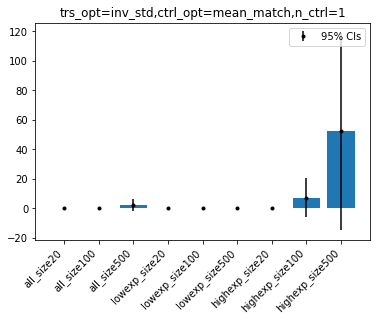

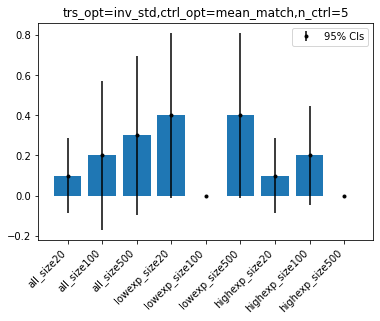

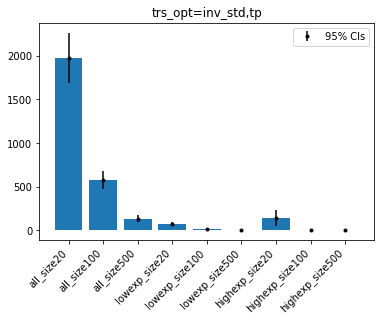

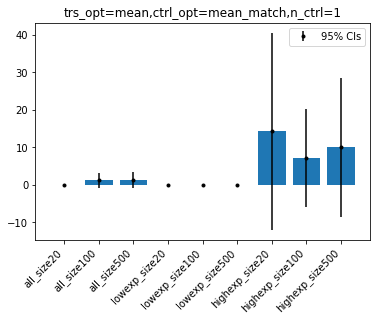

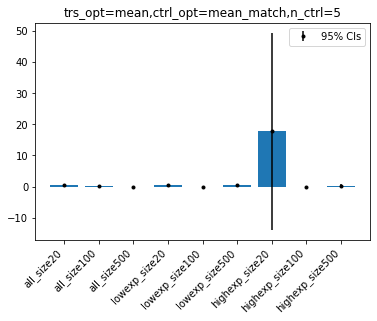

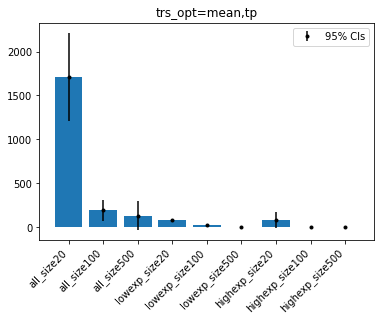

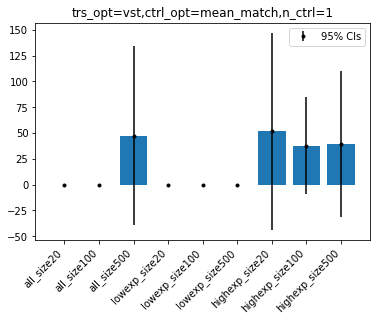

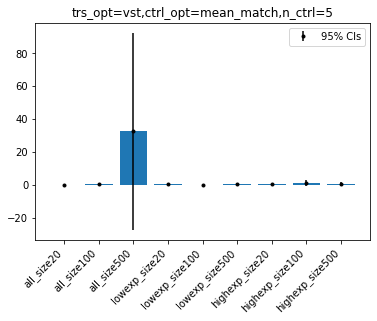

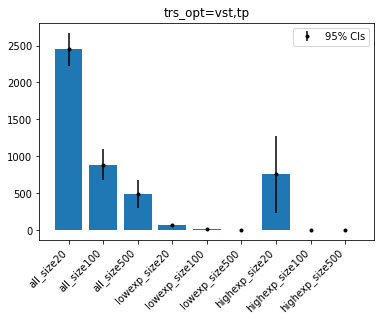

In [56]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']
for mname in md_list:
    plt.figure()
    plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]])
    plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]],
                 yerr=1.96*df_plot.loc[mname, ['%s.se'%x for x in trait_list]], color='k', fmt='.', label='95% CIs')
    plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
    plt.title(mname)
    plt.legend()
    plt.show()
#     break

### Old code 

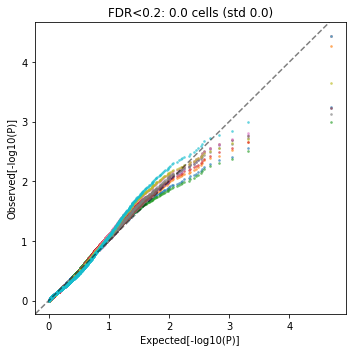

In [41]:
# QQ-plot 
normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)
plt.figure(figsize=[5,5])
v_nrej = []
for i_trait,trait in enumerate([x for x in dic_trs.keys() if 'trs_opt=vst,ctrl_opt=random,n_ctrl=1' in x]):
    v_p = dic_trs[trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    v_nlogp = -np.log10(v_p)
    util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5, color='C%d'%i_trait, label=trait)
    v_nrej.append((v_fdr<0.2).sum())
plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
v_nrej = np.array(v_nrej)
plt.title('FDR<0.2: %0.1f cells (std %0.1f)'%(v_nrej.mean(),v_nrej.std()))
plt.ylabel('Observed[-log10(P)]')
plt.xlabel('Expected[-log10(P)]')
# plt.legend()
plt.tight_layout()
plt.show()

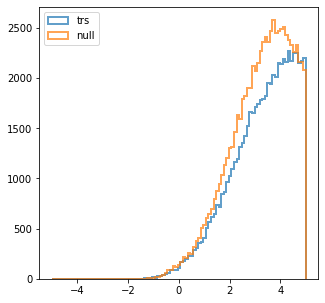

In [149]:
# Distribution plot
plot_alpha = 0.7
bins_ = np.linspace(-5,5,100)
fig = plt.figure(figsize=[5,5])
# original TRS
plt.hist(data_facs_ct.obs['trs'].values,
         histtype='step', bins=bins_, alpha=0.7, label='trs', linewidth=2)
plt.hist(data_facs_ct.obs['trs_null0'].values,
         histtype='step', bins=bins_, alpha=0.7, label='null', linewidth=2)
plt.legend(loc='upper left')
plt.show()

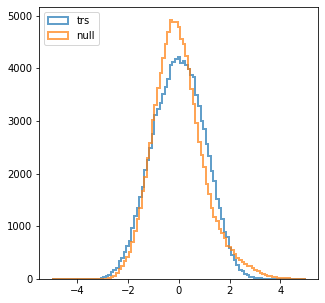

In [148]:
# Distribution plot
plot_alpha = 0.7
bins_ = np.linspace(-5,5,100)
fig = plt.figure(figsize=[5,5])
# original TRS
plt.hist(data_facs_ct.obs['trs_z'].values,
         histtype='step', bins=bins_, alpha=0.7, label='trs', linewidth=2)
plt.hist(data_facs_ct.obs['trs_null0_z'].values,
         histtype='step', bins=bins_, alpha=0.7, label='null', linewidth=2)
plt.legend(loc='upper left')
plt.show()